In [133]:
import ROOT as r
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from Event import Event

In [134]:
'''
Returns the time vs. x and time vs. y data from the pixel_hits. The ATAR is made up of sheets that contain alternating horizontal or vertical strips with npixels_per_plane.
If npixels_per_plane were 100, for instance, 100036 would represent plate 1, 36 / 100 in x, 100161 would represent plate 2, 61 / 100 in y, etc. The output for each of 
x and y is an n x 2 matrix, where the first column contains the times corresponding to the coordinate values in the second column.
Also extract the z (plane #) vs. time data. The third element of the tuples contained in this list and the x and y lists will contain corresponding colors to represent
when particles have decayed.
'''
def process_event(tree, event_index):
    #Get the specified entry so we can extract data from it.
    tree.GetEntry(event_index)

    #Store pixel hits for the entry printed above in which a pion didn't decay at rest.
    pixel_times = tree.pixel_time
    pixel_hits = tree.pixel_hits
    pixel_edep = tree.pixel_edep
    
    #Initialize lists for storing color (for labeling data points according to decay product), t, x, y, z, energy, and energy per plane using the Event class.
    npixels_per_plane = 100
    event = Event()

    #Init time value so 1st loop below works.
    cur_time = 0
    
    #Extract x vs. t, y vs. t, and z vs. t data. Also add indexed color coding to represent different particles.
    for i in range(pixel_hits.size()):
        plane = int(np.floor((pixel_hits[i] - 1 - 100_000) / npixels_per_plane))

        cur_val = (pixel_hits[i] - 1) % npixels_per_plane
        last_time = cur_time    #Allows us to note any large time gaps for later analysis.
        cur_time = pixel_times[i]

        event.t_data.append(cur_time)

        if(plane % 2 == 0):
            event.x_data.append(cur_val)
            event.y_data.append(np.nan)
        else:
            event.y_data.append(cur_val)
            event.x_data.append(np.nan)

        event.z_data.append(plane)
        event.E_data.append(pixel_edep[i])

        # #Keep track of any gaps in time between decays.
        if cur_time - last_time > 1.0:      #TODO: Adjust this time gap (in ns) as needed.
            event.gap_times.append(cur_time - last_time)

        #Keep track of sum of energies deposited in each plane.
        event.E_per_plane[plane] += pixel_edep[i]

    #Keep track of particle IDs.
    event.pixel_pdgs = tree.pixel_pdg

    #Keep track of maximum energy deposited per plane in this event.
    event.max_E = max(event.E_per_plane)

    return event

In [135]:
#Show some useful parameters describing our event.
def display_event(event):
    print("Length of pixel_pdgs: " + str(len(event.pixel_pdgs)))
    print("Length of t_data: " + str(len(event.t_data)))
    print("Length of x_data: " + str(len(event.x_data)))
    print("Length of y_data: " + str(len(event.y_data)))
    print("Length of z_data: " + str(len(event.z_data)))
    print("Length of E_data: " + str(len(event.E_data)))
    print("Length of E_per_plane: " + str(len(event.E_per_plane)))
    print("pixel_pdgs: " + str(event.pixel_pdgs))
    print("x_data: " + str(event.x_data))
    print("t_data: " + str(event.t_data))

In [136]:
#For each color in a list of color labels for different particles, plot the corresponding data.
def plot_with_color_legend(x_coords, y_coords, pixel_pdgs):
    #Store colors and corresponding particle type labels in one place for ease of editing.
    colors = ["r", "b", "g", "y", "m"]
    labels = ["Pion", "Positron", "Electron", "Antimuon", "Muon"]
    particle_IDs = [211, -11, 11, -13, 13]
    
    #Store list of tuples of our data to be processed below.
    coords = zip(x_coords, y_coords, pixel_pdgs)

    #Keep track of known particles and other particles to plot.
    cur_data_to_plot = []
    other_to_plot = []
    other_IDs = []
    other_colors = ["k", "gray", "cyan", "indigo", "teal", "lime"]

    #For each color, extract all pdgs of that color and display them on a scatter plot.
    for i in range(0, len(particle_IDs)):
        for coord in coords:
            if coord[2] == particle_IDs[i]:                
                cur_data_to_plot.append(coord)
            elif coord[2] not in particle_IDs:  # Keep track of number of unidentified particles so we can plot them separately after exiting this loop.
                other_to_plot.append(coord)

                #Keep list of other IDs so we know how many labels are needed.
                if coord[2] not in other_IDs:
                    other_IDs.append(coord[2])
                #str(pixel_pdg[i])
        
        #Plot data for corresponding color each loop, but only if the data for the corresponding color is not empty.
        if len(cur_data_to_plot) != 0:
            plt.scatter([coord[0] for coord in cur_data_to_plot], [coord[1] for coord in cur_data_to_plot], 10, colors[i], label = labels[i])

        #Reset data to plot every loop.
        cur_data_to_plot = []

    #Plot the unidentified particles in distinct colors with their pdgs for labels.
    for i in range(0, len(other_IDs)):
        ID = other_IDs[i]
        
        #Extract x and y coordinates to plot only if they are all of the particle ID that we are currently plotting.
        # [coord[0] for coord in other_to_plot if coord[2] == ID]
        x = []
        y = []
        for coord in other_to_plot:
            if coord[2] == ID:
                x.append(coord[0])
                y.append(coord[1])

        plt.scatter(x, y, 10, other_colors[i], label = str(ID))

#Plot x vs. t, y vs. t, z vs. t, and E vs. z data from our event. The graphs will show the color-coding system used to represent different particles.
#Display 0 to num_planes on plots including the z variable.
def plot_event(event, num_planes):

    plt.figure(figsize = (25, 6))

    plt.subplot(1,4,1)

    plot_with_color_legend(event.z_data, event.x_data, event.pixel_pdgs)
    plt.title("x vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("x (pix)")
    plt.legend()
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,2)
    plot_with_color_legend(event.z_data, event.y_data, event.pixel_pdgs)
    plt.title("y vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("y (pix)")
    plt.xlim(0, num_planes)
    plt.ylim(0, 100)

    plt.subplot(1,4,3)
    plot_with_color_legend(event.t_data, event.z_data, event.pixel_pdgs)
    plt.title("z vs. t")
    plt.xlabel("t (ns)")
    plt.ylabel("z (plane number)")
    # plt.xlim(0, 60)
    plt.ylim(0, num_planes)

    plt.subplot(1,4,4)

    plt.scatter(event.z_data, event.E_data, 10, label = "e_dep")
    plt.scatter(range(50), event.E_per_plane, 10, "black", label = "e_dep per plane")
    plt.title("ATAR Energy Deposition Per Plane vs. z")
    plt.xlabel("z (plane number)")
    plt.ylabel("Energy (MeV / plane)")
    plt.legend()
    #plt.xlim(0, num_planes)

    plt.subplots_adjust(left = 0.1,
                        bottom = 0.1, 
                        right = 0.9, 
                        top = 0.9, 
                        wspace = 0.5, 
                        hspace = 0.4)

In [137]:
#Use cuts to select the events we want from the tree. Returns an integer list of the indices of the events that we want from the tree.
#is_event_DAR: Value of 0 = decays in flight, 1 = decays at rest, 2 = all data used.
#num_events:  Controls how many events we want to select.
def select_events(tree, is_event_DAR, num_events):
    #Apply logical cut to select whether we want DARs and to exclude empty data. n stores the number of entries that satisfy this cut.
    if is_event_DAR == 0:
        cut = "!pion_dar && Sum$(pixel_edep) > 0"
    elif is_event_DAR == 1:
        cut = "pion_dar && Sum$(pixel_edep) > 0"
    else:
        cut = "Sum$(pixel_edep) > 0"
    n = tree.Draw("Entry$", cut, "goff")
    
    #Get all indices that satisfy the cut.
    events = []
    for i in range(n):
        events.append(tree.GetV1()[i])

    selected_events = events[0:num_events]
    print("Indices of selected events: " + str(selected_events))

    return [int(i) for i in selected_events]


#Combines the functions we created above to give a visualization of events with the specified condition(s).
#is_event_DAR: Value of 0 = decays in flight, 1 = decays at rest, 2 = all data used.
#display_text_output = True / False controls whether we should have text info / not have text info displayed.
#display_plots = True / False controls whether event data is plotted or not.
#num_events allows us to plot multiple events with the specified conditions from the tree.\
#gap_times = True / False means we should show / not show gap times between decays if any are present.
def event_visualization(tree, is_event_DAR, display_text_output, display_outliers, num_events):
    
    #Get num_events indices for events that satisfy DAR / DIF criteria.
    event_indices = select_events(tree, is_event_DAR, num_events)

    #Use max edep per plane as a heuristic to distinguish between DIFs and DARs.
    max_Es = []

    #Keep track of gap times.
    gap_times = []

    #For each of the event indices specified, process the corresponding event and display useful output if we want, then plot it.
    for i in range(len(event_indices)):
        e = process_event(tree, event_indices[i])

        if display_text_output:
            display_event(e)
        
        #Show events with abnormally large energies if we want.
        if display_outliers and e.max_E > 7.5:
            plot_event(e, 50)

        for gt in e.gap_times:
            gap_times.append(gt)

        max_Es.append(e.max_E)

        
    return (max_Es, gap_times)

In [138]:
#Compare the maximum energy deposition of decays in flight and decays at rest. Show mean, median, and standard deviation for both sets of maximum energies, then plot them in
#histogram form. One should notice that the DARs have a higher median energy deposited, though the means may be closer due to large outliers present in some DIF data.
#max_Es_DIF:  Data for maximum energies from decays in flight.
#max_Es_DAR:  Data for maximum energies from decays at rest.
#num_bins:  Controls the number of bins used when plotting data on histograms.
def compare_max_edep(max_Es_DIF, max_Es_DAR, num_bins):
    max_Es_DIF_mean = np.mean(max_Es_DIF)
    max_Es_DIF_median = np.median(max_Es_DIF)
    max_Es_DIF_std = np.std(max_Es_DIF)

    max_Es_DAR_mean = np.mean(max_Es_DAR)
    max_Es_DAR_median = np.median(max_Es_DAR)
    max_Es_DAR_std = np.std(max_Es_DAR)

    print("\nmax_Es_DIF_mean: " + str(max_Es_DIF_mean))
    print("max_Es_DIF_median: " + str(max_Es_DIF_median))
    print("max_Es_DIF_std: " + str(max_Es_DIF_std))

    print("\nmax_Es_DAR_mean: " + str(max_Es_DAR_mean))
    print("max_Es_DAR_median: " + str(max_Es_DAR_median))
    print("max_Es_DAR_std: " + str(max_Es_DAR_std))


    plt.figure(figsize = (20, 6))

    plt.hist(max_Es_DIF, num_bins, color = "blue", alpha = 0.5, label = "DIF")
    plt.hist(max_Es_DAR, num_bins, color = "orange", alpha = 0.5, label = "DAR")
    plt.title("Max Energy by Group for Decays in Flight and Decays at Rest")
    plt.xlabel("Max Energy by Group (MeV)")
    plt.ylabel("Count")
    plt.legend()

#Plots gap times given and visualizes how these correlate with DIFs / DARs.
#gap_times: A list of times in ns.
#gap_times_DIF:  Data for times between decays for DIFs in ns.
#gap_times_DAR:  Data for times between decays for DARs in ns.
#num_bins:  Controls the number of bins used when plotting data on histograms.
def compare_gap_times(gap_times_DIF, gap_times_DAR, num_bins):
    gap_times_DIF_mean = np.mean(gap_times_DIF)
    gap_times_DIF_median = np.median(gap_times_DIF)
    gap_times_DIF_std = np.std(gap_times_DIF)

    gap_times_DAR_mean = np.mean(gap_times_DAR)
    gap_times_DAR_median = np.median(gap_times_DAR)
    gap_times_DAR_std = np.std(gap_times_DAR)

    print("\ngap_times_DIF_mean: " + str(gap_times_DIF_mean))
    print("gap_times_DIF_median: " + str(gap_times_DIF_median))
    print("gap_times_DIF_std: " + str(gap_times_DIF_std))

    print("\ngap_times_DAR_mean: " + str(gap_times_DAR_mean))
    print("gap_times_DAR_median: " + str(gap_times_DAR_median))
    print("gap_times_DAR_std: " + str(gap_times_DAR_std))


    plt.figure(figsize = (20, 6))
    
    plt.hist(gap_times_DIF, num_bins, color = "green", alpha = 0.5, label = "DIF")
    plt.hist(gap_times_DAR, num_bins, color = "brown", alpha = 0.5, label = "DAR")
    plt.title("Gap Times for Decays in Flight and Decays at Rest")
    plt.xlabel("Time (ns)")
    plt.ylabel("Count")
    plt.legend()

Indices of selected events: [66.0, 102.0, 115.0, 117.0, 163.0, 166.0, 209.0, 308.0, 311.0, 318.0, 375.0, 437.0, 451.0, 601.0, 647.0, 654.0, 766.0, 811.0, 981.0, 1071.0, 1154.0, 1199.0, 1223.0, 1232.0, 1259.0, 1364.0, 1474.0, 1481.0, 1581.0, 1592.0, 1596.0, 1605.0, 1634.0, 1704.0, 1718.0, 2098.0, 2109.0, 2161.0, 2170.0, 2285.0, 2376.0, 2405.0, 2435.0, 2436.0, 2493.0, 2543.0, 2778.0, 2804.0, 2930.0, 2991.0, 3140.0, 3166.0, 3181.0, 3192.0, 3197.0, 3236.0, 3456.0, 3543.0, 3592.0, 3604.0, 3695.0, 3727.0, 3767.0, 3893.0, 3955.0, 4002.0, 4021.0, 4046.0, 4140.0, 4226.0, 4251.0, 4253.0, 4345.0, 4393.0, 4426.0, 4443.0, 4465.0, 4508.0, 4529.0, 4569.0, 4659.0, 4673.0, 4680.0, 4771.0, 4784.0, 4950.0, 5082.0, 5087.0, 5108.0, 5253.0, 5309.0, 5354.0, 5370.0, 5415.0, 5484.0, 5492.0, 5530.0, 5604.0, 5628.0, 5640.0]
Indices of selected events: [0.0, 1.0, 3.0, 4.0, 5.0, 7.0, 11.0, 12.0, 13.0, 14.0, 17.0, 18.0, 21.0, 22.0, 24.0, 25.0, 28.0, 29.0, 31.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 43.0, 44.0, 45.0, 

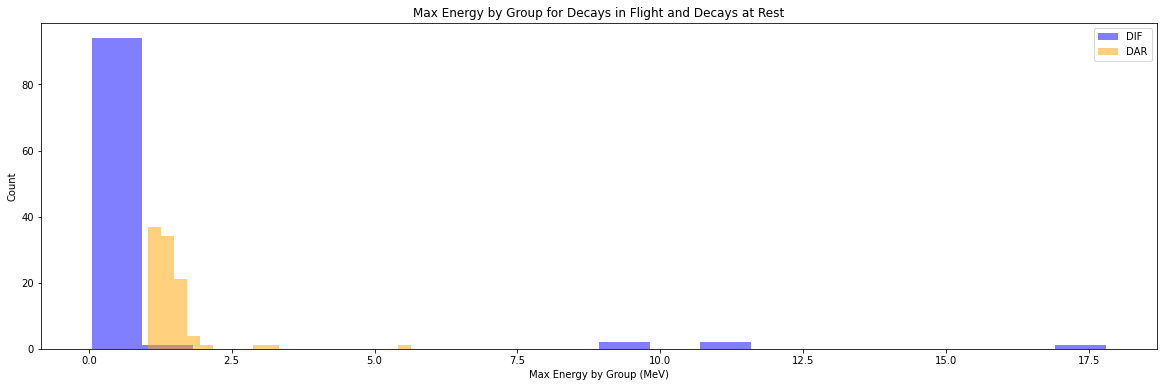

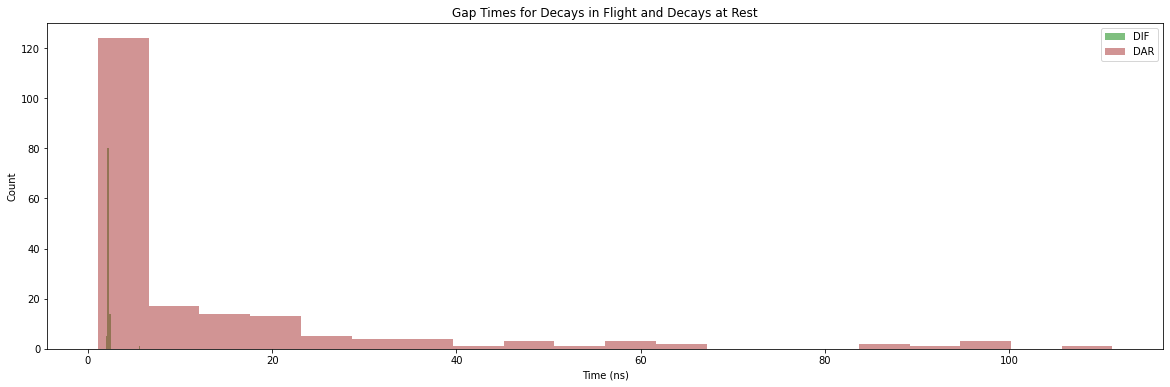

In [139]:
#Compare energy deposition and gap times of DARs and DIFs for pion --> e data.
PiEfile = r.TFile("pienux_out_stripped.root")
PiEtree = PiEfile.Get("atar")
# print([x.GetName() for x in tree.GetListOfBranches()])
# print("\n")

(max_Es_DIF, gap_times_DIF) = event_visualization(PiEtree, 0, False, False, 100)
(max_Es_DAR, gap_times_DAR) = event_visualization(PiEtree, 1, False, False, 100)

#TODO:  Also specify range in addition to num bins to ensure consistent bin size.
compare_max_edep(max_Es_DIF, max_Es_DAR, 20)
compare_gap_times(gap_times_DIF, gap_times_DAR, 20)

Indices of selected events: [66.0, 102.0, 115.0, 117.0, 163.0, 166.0, 209.0, 308.0, 311.0, 318.0, 375.0, 437.0, 451.0, 601.0, 647.0, 654.0, 766.0, 811.0, 981.0, 1071.0, 1154.0, 1199.0, 1223.0, 1232.0, 1259.0, 1364.0, 1474.0, 1481.0, 1581.0, 1592.0, 1596.0, 1605.0, 1634.0, 1704.0, 1718.0, 2098.0, 2109.0, 2161.0, 2170.0, 2285.0, 2376.0, 2405.0, 2435.0, 2436.0, 2493.0, 2543.0, 2778.0, 2804.0, 2930.0, 2991.0, 3140.0, 3166.0, 3181.0, 3192.0, 3197.0, 3236.0, 3456.0, 3543.0, 3592.0, 3604.0, 3695.0, 3727.0, 3767.0, 3893.0, 3955.0, 4002.0, 4021.0, 4046.0, 4140.0, 4226.0, 4251.0, 4253.0, 4345.0, 4393.0, 4426.0, 4443.0, 4465.0, 4508.0, 4529.0, 4569.0, 4659.0, 4673.0, 4680.0, 4771.0, 4784.0, 4950.0, 5082.0, 5087.0, 5108.0, 5253.0, 5309.0, 5354.0, 5370.0, 5415.0, 5484.0, 5492.0, 5530.0, 5604.0, 5628.0, 5640.0]


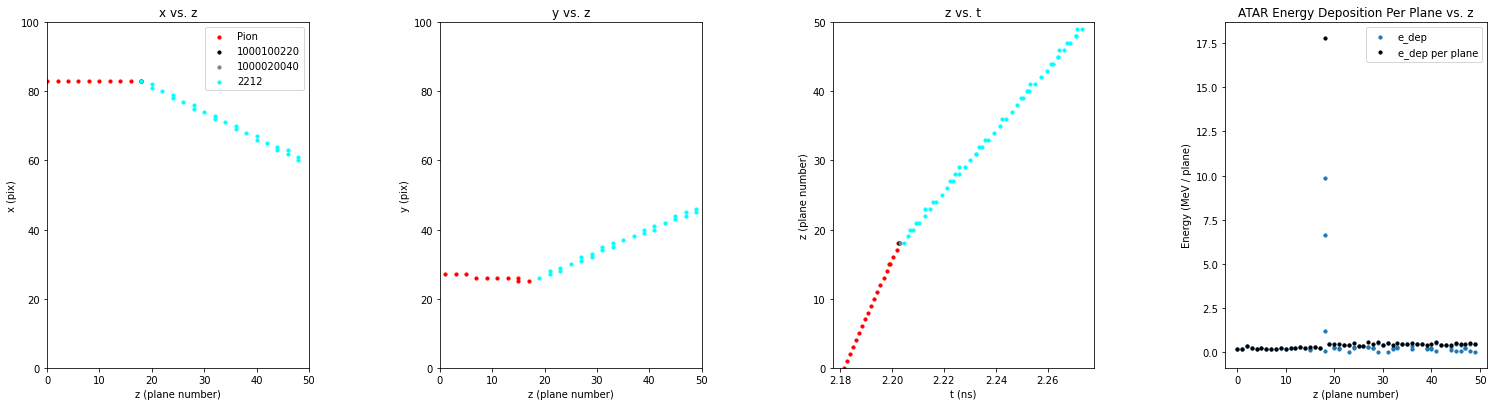

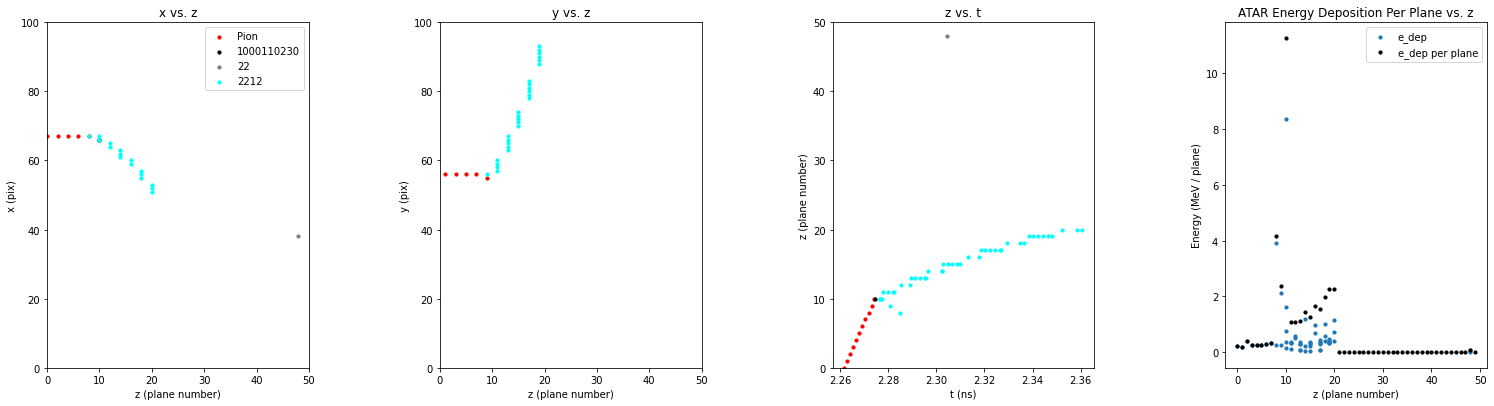

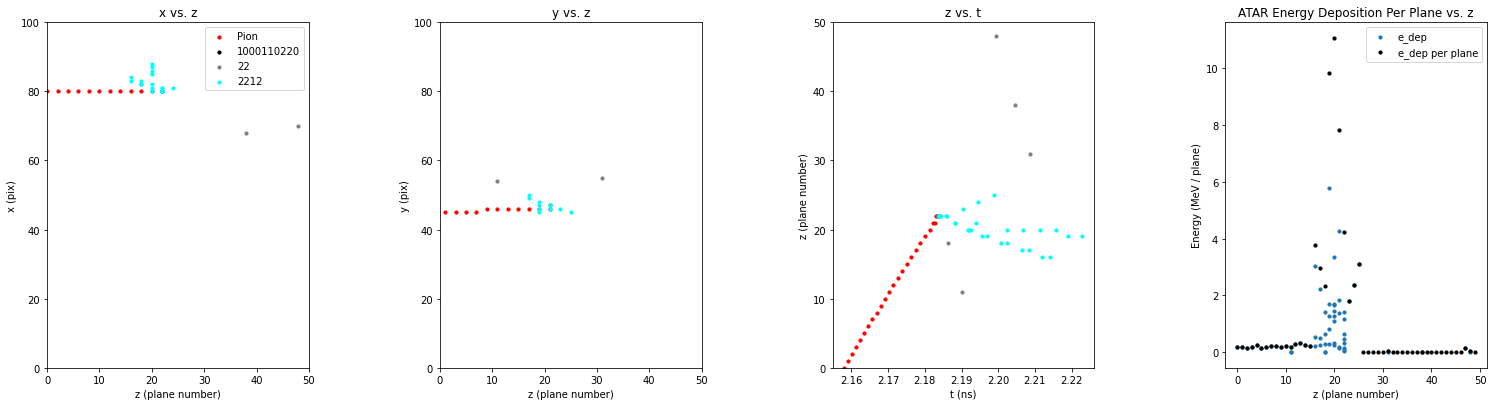

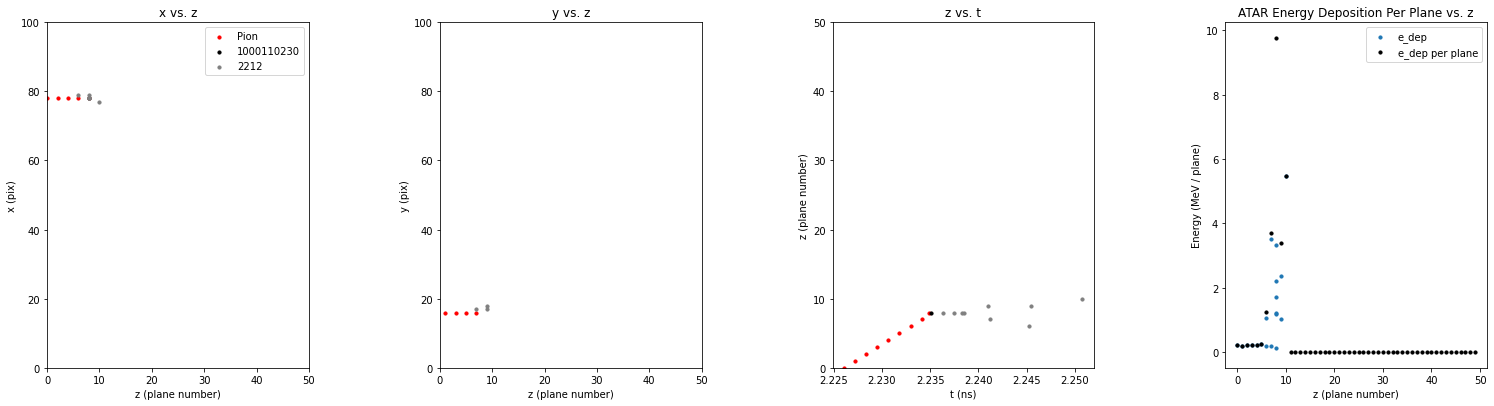

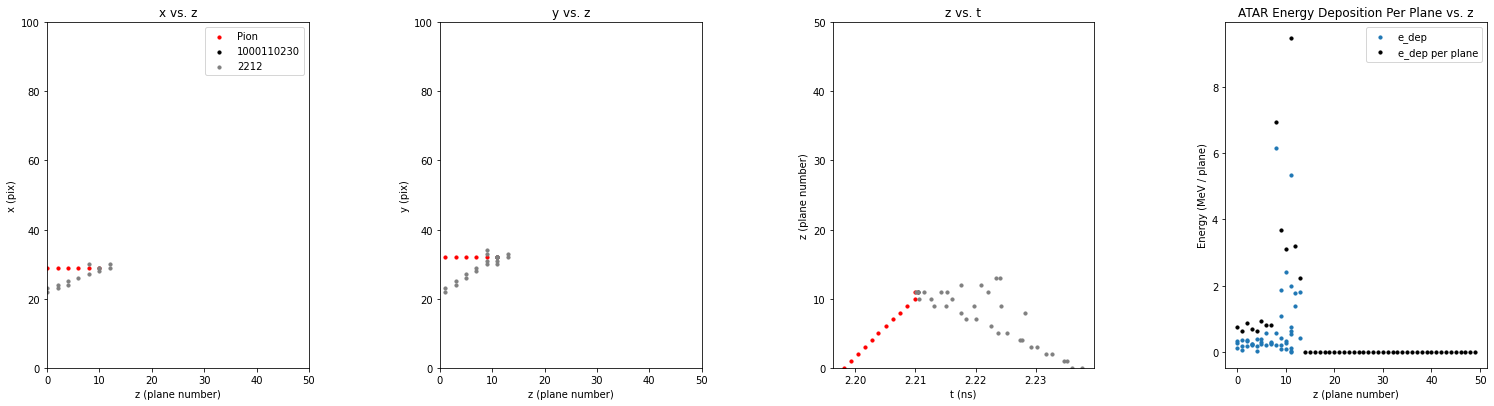

In [140]:
#Just look at outlier plots for the pion --> e data.
out_data = event_visualization(PiEtree, 0, False, True, 100)

Indices of selected events: [5.0, 126.0, 183.0, 280.0, 307.0, 310.0, 322.0, 435.0, 437.0, 466.0, 686.0, 710.0, 745.0, 781.0, 793.0, 821.0, 830.0, 850.0, 929.0, 996.0, 1148.0, 1168.0, 1177.0, 1193.0, 1314.0, 1422.0, 1438.0, 1446.0, 1475.0, 1576.0, 1661.0, 1675.0, 1741.0, 1748.0, 1880.0, 1930.0, 1968.0, 1980.0, 2024.0, 2079.0, 2230.0, 2319.0, 2376.0, 2387.0, 2421.0, 2554.0, 2620.0, 2621.0, 2665.0, 2675.0]
Indices of selected events: [0.0, 2.0, 6.0, 7.0, 8.0, 10.0, 11.0, 12.0, 14.0, 15.0, 16.0, 17.0, 19.0, 20.0, 24.0, 25.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0, 35.0, 37.0, 38.0, 40.0, 42.0, 44.0, 45.0, 46.0, 48.0, 51.0, 52.0, 53.0, 54.0, 56.0, 57.0, 60.0, 62.0, 63.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 74.0, 76.0, 77.0, 78.0]

max_Es_DIF_mean: 0.7775093897146701
max_Es_DIF_median: 0.37712941568260105
max_Es_DIF_std: 1.5108446773960504

max_Es_DAR_mean: 2.5033480678059106
max_Es_DAR_median: 2.1614422617968367
max_Es_DAR_std: 1.0977880430538707

gap_times_DIF_mean: 302.84110350597433
gap_time

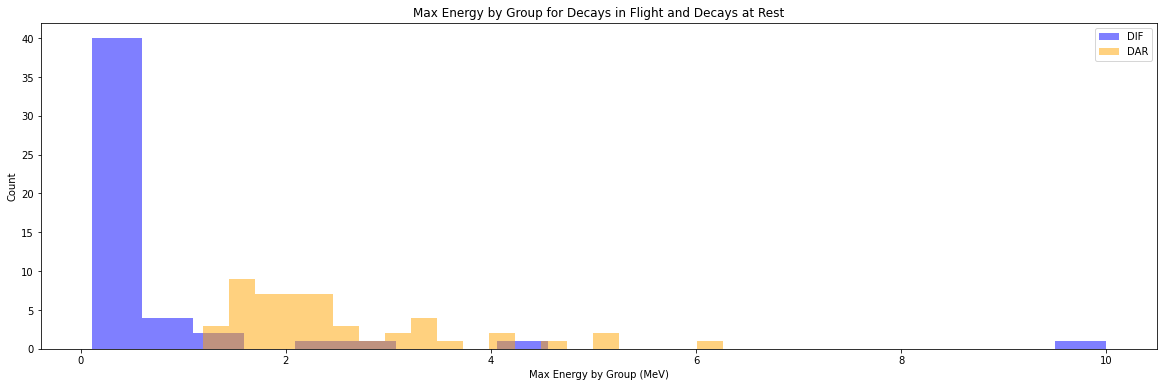

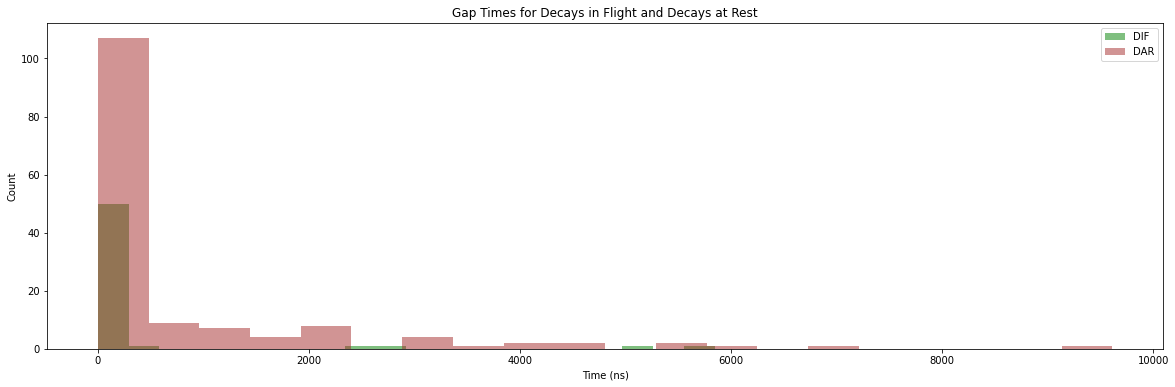

In [141]:
#Compare energy deposition and gap times of DARs and DIFs for pion --> muon --> e data.
PiMuEfile = r.TFile("pienux_out_stripped_muons.root")
PiMuEtree = PiMuEfile.Get("atar")
# print([x.GetName() for x in tree.GetListOfBranches()])
# print("\n")

(max_Es_DIF, gap_times_DIF) = event_visualization(PiMuEtree, 0, False, False, 50)
(max_Es_DAR, gap_times_DAR) = event_visualization(PiMuEtree, 1, False, False, 50)

compare_max_edep(max_Es_DIF, max_Es_DAR, 20)
compare_gap_times(gap_times_DIF, gap_times_DAR, 20)

Indices of selected events: [5.0, 126.0, 183.0, 280.0, 307.0, 310.0, 322.0, 435.0, 437.0, 466.0, 686.0, 710.0, 745.0, 781.0, 793.0, 821.0, 830.0, 850.0, 929.0, 996.0, 1148.0, 1168.0, 1177.0, 1193.0, 1314.0, 1422.0, 1438.0, 1446.0, 1475.0, 1576.0, 1661.0, 1675.0, 1741.0, 1748.0, 1880.0, 1930.0, 1968.0, 1980.0, 2024.0, 2079.0, 2230.0, 2319.0, 2376.0, 2387.0, 2421.0, 2554.0, 2620.0, 2621.0, 2665.0, 2675.0]


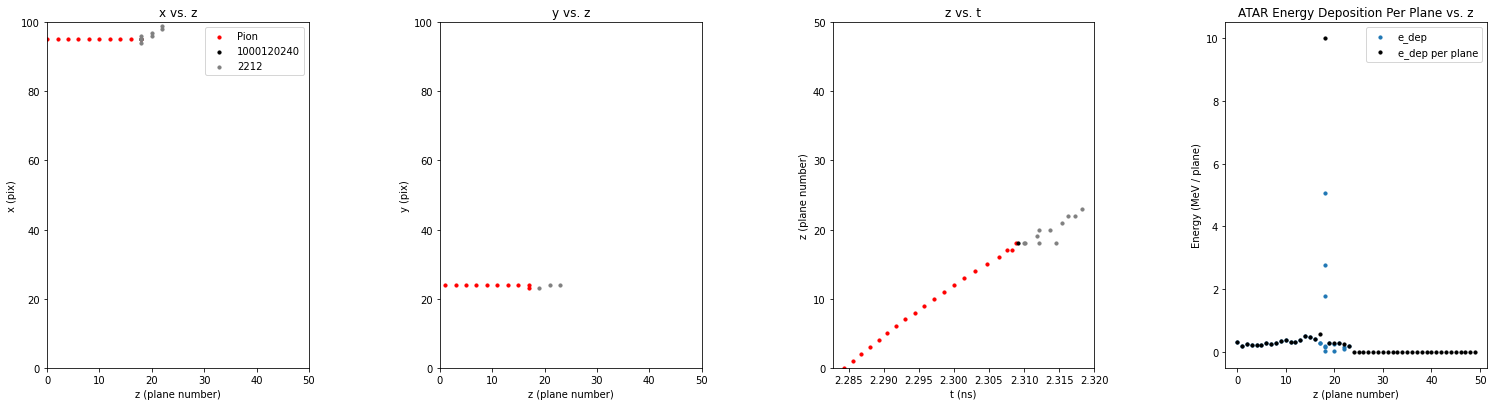

In [142]:
#Just look at outlier plots for the pion --> muon --> e data.
out_data = event_visualization(PiMuEtree, 0, False, True, 50)